In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw , Descriptors, AllChem, PandasTools, MACCSkeys, AtomPairs, rdFingerprintGenerator
from rdkit.Chem.rdmolops import  PatternFingerprint
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.AtomPairs.Pairs import GetAtomPairFingerprintAsBitVect


### load and clean data - ensure data has SMILES string, protein/ amino acid sequence and labels

In [4]:
df = pd.read_csv('/Users/samuelsetsofia/dev/projects/DTI_Crispy/BIOSNAP.csv')
df.head()

,SMILES,Target Sequence,Label
0,CC1=CN=C2N1C=CN=C2NCC1=CC=NC=C1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,0
1,C\C(\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C(/C)=C/C(O)=O,MYGNYSHFMKFPAGYGGSPGHTGSTSMSPSAALSTGKPMDSHPSYT...,1
2,[H][C@@]12N(C)C3=CC(OC)=C(C=C3[C@@]11CCN3CC=C[...,MATFVELSTKAKMPIVGLGTWKSPLGKVKEAVKVAIDAGYRHIDCA...,0
3,COC1=CC=CC=C1OCCNCC(O)COC1=CC=CC2=C1C1=CC=CC=C1N2,MGAGVLVLGASEPGNLSSAAPLPDGAATAARLLVPASPPASLLPPA...,1
4,[H][C@@](C)(NC1=CC2=C(C=N1)C(C)=NN2C1=CC=CC(CC...,MFIWTSGRTSSSYRHDEKRNIYQKIRDHDLLDKRKTVTALKAGEDR...,0


In [5]:
# df['Target Sequence']
df.info()
# df.dropna(inplace=  True)
# df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19234 entries, 0 to 19233
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SMILES           19234 non-null  object
 1   Target Sequence  19234 non-null  object
 2   Label            19234 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 450.9+ KB


### convert smile strings to mol_obj - uses the rdkit

In [6]:
PandasTools.AddMoleculeColumnToFrame(df, 'SMILES','mol_obj')
df.head()

[19:01:17] Unusual charge on atom 0 number of radical electrons set to zero
[19:01:17] Unusual charge on atom 0 number of radical electrons set to zero


,SMILES,Target Sequence,Label,mol_obj
0,CC1=CN=C2N1C=CN=C2NCC1=CC=NC=C1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...,0,<rdkit.Chem.rdchem.Mol object at 0x1613638b0>
1,C\C(\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C(/C)=C/C(O)=O,MYGNYSHFMKFPAGYGGSPGHTGSTSMSPSAALSTGKPMDSHPSYT...,1,<rdkit.Chem.rdchem.Mol object at 0x161363990>
2,[H][C@@]12N(C)C3=CC(OC)=C(C=C3[C@@]11CCN3CC=C[...,MATFVELSTKAKMPIVGLGTWKSPLGKVKEAVKVAIDAGYRHIDCA...,0,<rdkit.Chem.rdchem.Mol object at 0x161363a00>
3,COC1=CC=CC=C1OCCNCC(O)COC1=CC=CC2=C1C1=CC=CC=C1N2,MGAGVLVLGASEPGNLSSAAPLPDGAATAARLLVPASPPASLLPPA...,1,<rdkit.Chem.rdchem.Mol object at 0x161363a70>
4,[H][C@@](C)(NC1=CC2=C(C=N1)C(C)=NN2C1=CC=CC(CC...,MFIWTSGRTSSSYRHDEKRNIYQKIRDHDLLDKRKTVTALKAGEDR...,0,<rdkit.Chem.rdchem.Mol object at 0x161363ae0>


### extract multiple fingerprint from SMILES extracted mol_obj

In [7]:
# Create an empty list to store MACCS fingerprints
df_maccs = []

# Run a for loop to iterate through each molecule
for mol in df['mol_obj']:
    # Generate bitvector object for MACCS keys
    maccs_bitvector = MACCSkeys.GenMACCSKeys(mol)
    # Create an empty array to store the bit vector as a numpy array
    arr = np.zeros((maccs_bitvector.GetNumBits(),), dtype=np.int8)
    # Convert the RDKit explicit vectors into numpy arrays
    DataStructs.ConvertToNumpyArray(maccs_bitvector, arr)
    # Append the array to the list
    df_maccs.append(arr)

# Convert list of arrays into a DataFrame
maccs_df = pd.DataFrame(df_maccs)

# Label each column with "MACCS_" prefix and unique identifier
maccs_df.columns = [f"MACCS_{i+1}" for i in range(maccs_df.shape[1])]

# Concatenate original DataFrame and the MACCS embeddings DataFrame
MACCS = pd.concat([df, maccs_df], axis=1)

# Select only the MACCS embedding columns for further analysis
MACCS_embeddings = MACCS.drop(MACCS.columns[:4], axis=1)

MACCS_embeddings.head()


,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,MACCS_10,...,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166,MACCS_167
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0


In [8]:


# Create an empty list to store APF fingerprints
df_apf = []

# Initialize the Atom Pair fingerprint generator with the desired fingerprint size
apgen = rdFingerprintGenerator.GetAtomPairGenerator(fpSize=4096)

# Run a for loop to iterate through each molecule
for mol in df['mol_obj']:
    # Generate the APF bitvector for the molecule
    apf_bitvector = apgen.GetFingerprint(mol)
    # Convert the RDKit bitvector into a numpy array
    arr = np.zeros((4096,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(apf_bitvector, arr)
    # Append the numpy array to the list
    df_apf.append(arr)

# Convert the list of arrays into a DataFrame
apf_df = pd.DataFrame(df_apf)

# Label each column with "APF_" prefix and a unique identifier
apf_df.columns = [f"APF_{i+1}" for i in range(apf_df.shape[1])]

# Concatenate the original DataFrame with the APF embeddings DataFrame
APF = pd.concat([df, apf_df], axis=1)

# Select only the APF embedding columns for further analysis
APF_embedding = APF.drop(APF.columns[:4], axis=1)

# Display the first few rows of the APF embedding DataFrame
APF_embedding.head()


,APF_1,APF_2,APF_3,APF_4,APF_5,APF_6,APF_7,APF_8,APF_9,APF_10,...,APF_4087,APF_4088,APF_4089,APF_4090,APF_4091,APF_4092,APF_4093,APF_4094,APF_4095,APF_4096
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:


# Create an empty list to store TTF fingerprints
df_ttf = []

# Initialize the Topological Torsion fingerprint generator with a specified fingerprint size
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048)

# Run a for loop to iterate through each molecule
for mol in df['mol_obj']:
    # Generate the TTF bitvector for the molecule
    ttf_bitvector = ttgen.GetFingerprint(mol)
    # Convert the RDKit bitvector into a numpy array
    arr = np.zeros((2048,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(ttf_bitvector, arr)
    # Append the numpy array to the list
    df_ttf.append(arr)

# Convert the list of arrays into a DataFrame
ttf_df = pd.DataFrame(df_ttf)

# Label each column with "TTF_" prefix and a unique identifier
ttf_df.columns = [f"TTF_{i+1}" for i in range(ttf_df.shape[1])]

# Concatenate the original DataFrame with the TTF embeddings DataFrame
TTF = pd.concat([df, ttf_df], axis=1)

# Select only the TTF embedding columns for further analysis
TTF_embedding = TTF.drop(TTF.columns[:4], axis=1)

# Display the resulting TTF embedding DataFrame
TTF_embedding.head()


,TTF_1,TTF_2,TTF_3,TTF_4,TTF_5,TTF_6,TTF_7,TTF_8,TTF_9,TTF_10,...,TTF_2039,TTF_2040,TTF_2041,TTF_2042,TTF_2043,TTF_2044,TTF_2045,TTF_2046,TTF_2047,TTF_2048
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:


# Create an empty list to store Pattern Fingerprint (PF) embeddings
df_pf = []

# Run a for loop to iterate through each molecule
for mol in df['mol_obj']:
    # Generate the Pattern Fingerprint bitvector for the molecule
    pf_bitvector = PatternFingerprint(mol)
    # Initialize a numpy array with the appropriate size
    arr = np.zeros((pf_bitvector.GetNumBits(),), dtype=np.int8)
    # Convert the RDKit bitvector into a numpy array
    DataStructs.ConvertToNumpyArray(pf_bitvector, arr)
    # Append the numpy array to the list
    df_pf.append(arr)

# Convert the list of arrays into a DataFrame
pf_df = pd.DataFrame(df_pf)

# Label each column with "PF_" prefix and a unique identifier
pf_df.columns = [f"PF_{i+1}" for i in range(pf_df.shape[1])]

# Concatenate the original DataFrame with the PF embeddings DataFrame
PF = pd.concat([df, pf_df], axis=1)

# Select only the PF embedding columns for further analysis
PF_embeddings = PF.drop(PF.columns[:4], axis=1)

# Display the first few rows of the PF embedding DataFrame
PF_embeddings.head()


,PF_1,PF_2,PF_3,PF_4,PF_5,PF_6,PF_7,PF_8,PF_9,PF_10,...,PF_2039,PF_2040,PF_2041,PF_2042,PF_2043,PF_2044,PF_2045,PF_2046,PF_2047,PF_2048
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0
3,0,1,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
4,0,1,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0


### protein one hot emcoding - convert protein sequence to OHE embeddings


In [11]:
# Define the amino acid alphabet and one-hot encoding mapping
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

def one_hot_encode_sequence(seq):
    # Initialize zero matrix for the sequence length x 20 amino acids
    ohe = np.zeros((len(seq), len(amino_acids)), dtype=int)
    for i, aa in enumerate(seq):
        if aa in aa_to_int:
            ohe[i, aa_to_int[aa]] = 1
    return ohe.flatten()  # Flatten the array to make it 1D for each protein

# Apply one-hot encoding to each sequence and store in new column
df['Protein_OHE'] = df['Target Sequence'].apply(one_hot_encode_sequence)
protein_embedding = df['Protein_OHE']

# Display the first few rows of the DataFrame with the new column
# print(df[['Target Sequence', 'Protein_OHE']].head())
protein_embedding.head()

#

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
Name: Protein_OHE, dtype: object

In [15]:


# Example: Protein_OHE column containing lists of one-hot encoded values
# protein_embedding.head() shows the structure provided.

# Expand the 'Protein_OHE' column into a DataFrame with individual columns
protein_ohe_df = pd.DataFrame(
    protein_embedding.tolist(),  # Convert list-like column into a DataFrame
    index=protein_embedding.index  # Maintain the original DataFrame index
)

# Rename columns to prot_ohe_1, prot_ohe_2, ..., prot_ohe_n
protein_ohe_df.columns = [f'prot_ohe_{i+1}' for i in range(protein_ohe_df.shape[1])]

protein_ohe_df.fillna(0, inplace=True)
protein_ohe_df
# Set maximum number of columns to keep
max_length = 1000  # Adjust based on requirement

# Keep only the first `max_length` columns
if protein_ohe_df.shape[1] > max_length:
    protein_ohe_df = protein_ohe_df.iloc[:, :max_length]

# Concatenate the expanded columns back with the original DataFrame (if necessary)
protein_embedding_expanded = pd.concat([protein_embedding, protein_ohe_df], axis=1)

# Drop the original 'Protein_OHE' column, if it's no longer needed
protein_embedding_expanded = protein_embedding_expanded.drop('Protein_OHE', axis=1, errors='ignore')

# Output the resulting DataFrame
print(protein_ohe_df.head())


   prot_ohe_1  prot_ohe_2  prot_ohe_3  prot_ohe_4  prot_ohe_5  prot_ohe_6  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   prot_ohe_7  prot_ohe_8  prot_ohe_9  prot_ohe_10  ...  prot_ohe_991  \
0           0           0           0            0  ...             0   
1           0           0           0            0  ...             0   
2           0           0           0            0  ...             0   
3           0           0           0            0  ...             0   
4           0           0           0            0  ...             0   

   prot_ohe_992  prot_ohe_993  prot_ohe_994  prot_ohe_995  prot_ohe_996  \
0             0        

### put the extracted embeddings and label into one dataframe

In [16]:
labels = df['Label']
labels.head()

0    0
1    1
2    0
3    1
4    0
Name: Label, dtype: int64

In [17]:
df_embeddings = pd.concat([ protein_ohe_df,MACCS_embeddings, TTF_embedding, PF_embeddings, APF_embedding, labels], axis=1)
df_embeddings.head()

,prot_ohe_1,prot_ohe_2,prot_ohe_3,prot_ohe_4,prot_ohe_5,prot_ohe_6,prot_ohe_7,prot_ohe_8,prot_ohe_9,prot_ohe_10,...,APF_4088,APF_4089,APF_4090,APF_4091,APF_4092,APF_4093,APF_4094,APF_4095,APF_4096,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### perform PCA - skip to data spliting for model training

In [21]:
# Step 1: Separate Features and Labels
features = df_embeddings.drop(columns=["Label"])  # Replace "Label" with the actual label column name
labels = df_embeddings["Label"]

# Step 2: Standardize Features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)

# Step 3: Perform PCA
# Retain components that explain 95% of the variance
pca = PCA(n_components=0.95, svd_solver='auto')  # Adjust n_components to a fixed number if preferred (e.g., 100)

# Fit and transform the standardized data
reduced_features = pca.fit_transform(standardized_features)

# Step 4: Analyze Results
print("Original Features Shape:", features.shape)
print("Reduced Features Shape:", reduced_features.shape)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_))

# Step 5: Combine Reduced Features with Labels
# Convert the reduced features to a DataFrame
reduced_df = pd.DataFrame(reduced_features)

# Add the 'Label' column back to the reduced dataset (without altering the original names)
reduced_df["Label"] = labels.reset_index(drop=True)

# Step 6: Save Reduced Dataset
reduced_df.to_csv("reduced_embeddings.csv", index=False)


Original Features Shape: (19234, 9359)
Reduced Features Shape: (19234, 2004)
Explained Variance Ratio: [9.77985338e-02 3.76132395e-02 2.22465831e-02 ... 5.87833931e-05
 5.86610861e-05 5.86395173e-05]
Total Variance Explained: 0.950012059716237


### perform feature corelation to delete highly corelated features, using aggregated data and confusion matrix - skip if you already performed pca for feature selection

In [13]:

# Separate fingerprint types by their column name patterns
maccs_cols = [col for col in df_embeddings.columns if 'MACCS_' in col]
pf_cols = [col for col in df_embeddings.columns if 'PF_' in col]
# mf_cols = [col for col in df_embeddings.columns if 'MF_' in col]
tf_cols = [col for col in df_embeddings.columns if 'TF_' in col]
apf_cols = [col for col in df_embeddings.columns if 'APF_' in col]

# Aggregate each fingerprint into one array per row
df_embeddings['MACCS_FINGERPRINT'] = df_embeddings[maccs_cols].values.tolist()
df_embeddings['PF_FINGERPRINT'] = df_embeddings[pf_cols].values.tolist()
# df_embeddings['MF_FINGERPRINT'] = df_embeddings[mf_cols].values.tolist()
df_embeddings['TF_FINGERPRINT'] = df_embeddings[tf_cols].values.tolist()
df_embeddings['APF_FINGERPRINT'] = df_embeddings[apf_cols].values.tolist()

# Create a new DataFrame with only aggregated fingerprints, Protein_OHE, and Label
df_agg = df_embeddings[['Protein_OHE', 'MACCS_FINGERPRINT', 'PF_FINGERPRINT', 
                         'TF_FINGERPRINT', 'APF_FINGERPRINT', 'Label']]

# Display the structure of the new DataFrame
df_agg.head()


,Protein_OHE,MACCS_FINGERPRINT,PF_FINGERPRINT,TF_FINGERPRINT,APF_FINGERPRINT,Label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


/var/folders/kg/_p0s7sk12zjf3tcq36hs8tpc0000gn/T/ipykernel_15285/426461599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['MACCS_Mean'] = df_agg['MACCS_FINGERPRINT'].apply(np.mean)
/var/folders/kg/_p0s7sk12zjf3tcq36hs8tpc0000gn/T/ipykernel_15285/426461599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agg['PF_Mean'] = df_agg['PF_FINGERPRINT'].apply(np.mean)
/var/folders/kg/_p0s7sk12zjf3tcq36hs8tpc0000gn/T/ipykernel_15285/426461599.py:5: SettingWithCopyWarning: 
A value is trying to be se

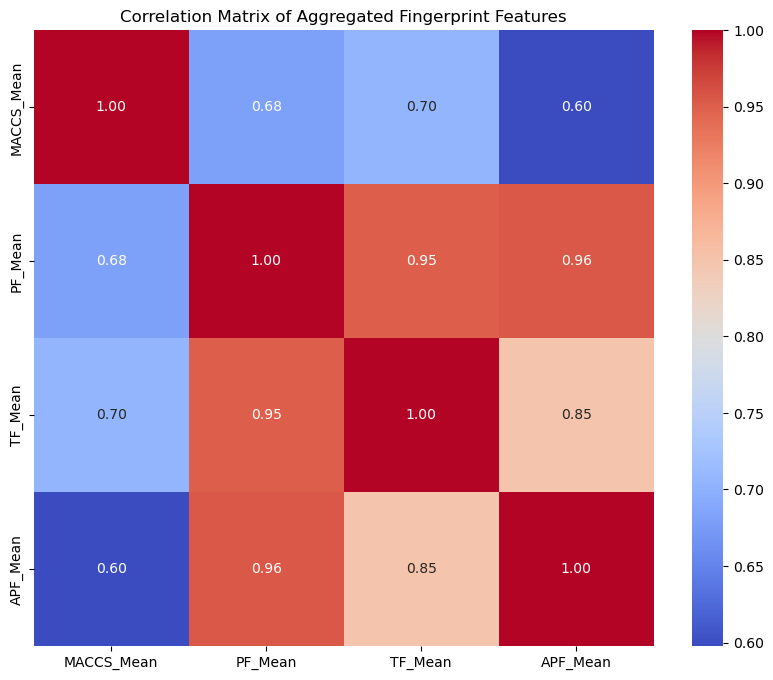

In [14]:


# Calculate the mean of each fingerprint array for correlation analysis
df_agg['MACCS_Mean'] = df_agg['MACCS_FINGERPRINT'].apply(np.mean)
df_agg['PF_Mean'] = df_agg['PF_FINGERPRINT'].apply(np.mean)
df_agg['TF_Mean'] = df_agg['TF_FINGERPRINT'].apply(np.mean)
df_agg['APF_Mean'] = df_agg['APF_FINGERPRINT'].apply(np.mean)

# Calculate the mean for the Protein_OHE if required (assuming it’s a list)
df_agg['Protein_OHE_Mean'] = df_agg['Protein_OHE'].apply(np.mean)

# Select only the mean columns and the Label column for correlation
correlation_df = df_agg[['MACCS_Mean', 'PF_Mean', 'TF_Mean', 'APF_Mean']]

# Compute the correlation matrix
correlation_matrix = correlation_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Aggregated Fingerprint Features')
plt.show()

In [15]:

# Filter out columns that start with APF_ or PF_
columns_to_keep = [col for col in df_embeddings.columns if not (col.startswith('APF_') or col.startswith('PF_'))]
df_embeddings_cleaned = df_embeddings[columns_to_keep]

In [16]:
# df_embeddings_cleaned.head()
# df_embeddings_cleaned.to_csv('df_embeddings_cleaned.csv')
df_embeddings_cleaned.head()

,Protein_OHE,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,...,TTF_2042,TTF_2043,TTF_2044,TTF_2045,TTF_2046,TTF_2047,TTF_2048,Label,MACCS_FINGERPRINT,TF_FINGERPRINT
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."


In [21]:

# df_embeddings_cleaned = df_embeddings_cleaned.iloc[:, :-1]
# df_embeddings_cleaned.to_csv('df_embeddings_cleaned.csv') 
# df_embeddings_cleaned = df_embeddings_cleaned.iloc[:, :-1]
df_embeddings_cleaned.head()

,Protein_OHE,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,...,TTF_2040,TTF_2041,TTF_2042,TTF_2043,TTF_2044,TTF_2045,TTF_2046,TTF_2047,TTF_2048,Label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df.head()

,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,MACCS_10,...,Protein_OHE_991,Protein_OHE_992,Protein_OHE_993,Protein_OHE_994,Protein_OHE_995,Protein_OHE_996,Protein_OHE_997,Protein_OHE_998,Protein_OHE_999,Protein_OHE_1000
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### split and save your data for model training

In [22]:
from sklearn.model_selection import train_test_split

# Load your data (if it is already loaded, you can skip this part)
# df = pd.read_csv("reduced_embedding.csv") use this if you used pca for feature selection
# df = pd.read_csv("df.csv") use this if you used aggregated confusion matrix for feature selection

# Separate features and target
X = reduced_df.drop(columns=['Label'])  # Adjust if your target column has a different name
y = reduced_df['Label']

# First, split into train and remaining (80% train, 20% remaining)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the remaining 20% into validation and test sets (10% each)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Combine features and target for each split and save them as CSV files
train_data = X_train.copy()
train_data['Label'] = y_train
train_data.to_csv("data/train_data.csv", index=False)

valid_data = X_valid.copy()
valid_data['Label'] = y_valid
valid_data.to_csv("data/valid_data.csv", index=False)

test_data = X_test.copy()
test_data['Label'] = y_test
test_data.to_csv("data/test_data.csv", index=False)

print("Datasets have been split and saved as train_data.csv, valid_data.csv, and test_data.csv.")


Datasets have been split and saved as train_data.csv, valid_data.csv, and test_data.csv.


### model training and evaluation

In [3]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_data(train_path, valid_path, test_path):
    # Load datasets
    train_df = pd.read_csv(train_path)
    valid_df = pd.read_csv(valid_path)
    test_df = pd.read_csv(test_path)
    
    # Separate features and target
    X_train = train_df.drop('Label', axis=1)
    y_train = train_df['Label']
    
    X_valid = valid_df.drop('Label', axis=1)
    y_valid = valid_df['Label']
    
    X_test = test_df.drop('Label', axis=1)
    y_test = test_df['Label']
    
    # Return dictionary containing all splits
    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'X_test': X_test,
        'y_test': y_test
    }

def evaluate_model(model, X, y, model_name, scaler=None):
    # Scale features if scaler is provided
    if scaler is not None:
        X = scaler.transform(X)
    
    # Get predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Print evaluation metrics
    print("\n" + "="*50)
    print(f"{model_name} Evaluation")
    print("="*50)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1score = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    
    # Print detailed metrics with formatting
    print("\nDetailed Performance Metrics:")
    print(f"{'Accuracy:':<15} {accuracy:.4f}")
    print(f"{'Precision:':<15} {precision:.4f}")
    print(f"{'Recall:':<15} {recall:.4f}")
    print(f"{'F1 Score:':<15} {f1score:.4f}")
    print(f"{'ROC AUC:':<15} {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
   
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1score': f1score,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

def train_and_evaluate_models(data_dict, random_state=42):
    # Extract data
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_valid = data_dict['X_valid']
    y_valid = data_dict['y_valid']
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    # Scale features for MLP
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Initialize models
    xgb_model = XGBClassifier( learning_rate=0.1, n_estimators=200, max_depth=6, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, random_state=random_state)
    
    mlp_model = MLPClassifier( hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', max_iter=500, random_state=random_state)
    
    # Train models
    print("Training XGBoost model...")
    xgb_model.fit(X_train, y_train)
   
    print("\nTraining Set Evaluation XGBoost:")
    xgb_train_metrics = evaluate_model(xgb_model, X_train, y_train, "XGBoost")
    
    
    print("\nTraining MLP model...")
    mlp_model.fit(X_train_scaled, y_train)


    print("\nTraining Set Evaluation MLP:")
    mlp_train_metrics = evaluate_model(mlp_model, X_valid, y_valid, "MLP", scaler)

    # Evaluate on validation set
    print("\nValidation Set Evaluation:")
    xgb_valid_metrics = evaluate_model(xgb_model, X_valid, y_valid, "XGBoost")
    mlp_valid_metrics = evaluate_model(mlp_model, X_valid, y_valid, "MLP", scaler)
    
    # Evaluate on test set
    print("\nTest Set Evaluation:")
    xgb_test_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
    mlp_test_metrics = evaluate_model(mlp_model, X_test, y_test, "MLP", scaler)
    
    return {
        'models': {
            'xgboost': xgb_model,
            'mlp': mlp_model
        },
        'scaler': scaler,
        'metrics': {
            'training': {
                'xgboost': xgb_train_metrics,
                'mlp': mlp_train_metrics
            },
            'validation': {
                'xgboost': xgb_valid_metrics,
                'mlp': mlp_valid_metrics
            },
            'test': {
                'xgboost': xgb_test_metrics,
                'mlp': mlp_test_metrics
            }
        }
    }


train_path = '/Users/samuelsetsofia/dev/projects/DTI_Crispy/data/train_data.csv'
valid_path = '/Users/samuelsetsofia/dev/projects/DTI_Crispy/data/valid_data.csv'
test_path = '/Users/samuelsetsofia/dev/projects/DTI_Crispy/data/test_data.csv'

# Load data
print("Loading data...")
data_dict = load_data(train_path, valid_path, test_path)

# Train and evaluate models
print("Training and evaluating models...")
results = train_and_evaluate_models(data_dict)

# Print final validation and test metrics
print("\nTraining Metrics:")
print(f"XGBoost ROC AUC: {results['metrics']['training']['xgboost']['roc_auc']:.3f}")
print(f"MLP ROC AUC: {results['metrics']['training']['mlp']['roc_auc']:.3f}")
print(f"XGBoost Accuracy: {results['metrics']['training']['xgboost']['accuracy']:.3f}")
print(f"MLP Accuracy: {results['metrics']['training']['mlp']['accuracy']:.3f}")
print(f"XGBoost Precision: {results['metrics']['training']['xgboost']['precision']:.3f}")
print(f"MLP Precision: {results['metrics']['training']['mlp']['precision']:.3f}")
print(f"XGBoost Recall: {results['metrics']['training']['xgboost']['recall']:.3f}")
print(f"MLP Recall: {results['metrics']['training']['mlp']['recall']:.3f}")
print(f"XGBoost F1score: {results['metrics']['training']['xgboost']['f1score']:.3f}")
print(f"MLP F1score: {results['metrics']['training']['mlp']['f1score']:.3f}")

print("\nFinal Validation Metrics:")
print(f"XGBoost ROC AUC: {results['metrics']['validation']['xgboost']['roc_auc']:.3f}")
print(f"MLP ROC AUC: {results['metrics']['validation']['mlp']['roc_auc']:.3f}")
print(f"XGBoost Accuracy: {results['metrics']['validation']['xgboost']['accuracy']:.3f}")
print(f"MLP Accuracy: {results['metrics']['validation']['mlp']['accuracy']:.3f}")
print(f"XGBoost Precision: {results['metrics']['validation']['xgboost']['precision']:.3f}")
print(f"MLP Precision: {results['metrics']['validation']['mlp']['precision']:.3f}")
print(f"XGBoost Recall: {results['metrics']['validation']['xgboost']['recall']:.3f}")
print(f"MLP Recall: {results['metrics']['validation']['mlp']['recall']:.3f}")
print(f"XGBoost F1score: {results['metrics']['validation']['xgboost']['f1score']:.3f}")
print(f"MLP F1score: {results['metrics']['validation']['mlp']['f1score']:.3f}")

print("\nFinal Test Metrics:")
print(f"XGBoost ROC AUC: {results['metrics']['test']['xgboost']['roc_auc']:.3f}")
print(f"MLP ROC AUC: {results['metrics']['test']['mlp']['roc_auc']:.3f}")
print(f"XGBoost Accuracy: {results['metrics']['test']['xgboost']['accuracy']:.3f}")
print(f"MLP Accuracy: {results['metrics']['test']['mlp']['accuracy']:.3f}")
print(f"XGBoost Precision: {results['metrics']['test']['xgboost']['precision']:.3f}")
print(f"MLP Precision: {results['metrics']['test']['mlp']['precision']:.3f}")
print(f"XGBoost Recall: {results['metrics']['test']['xgboost']['recall']:.3f}")
print(f"MLP Recall: {results['metrics']['test']['mlp']['recall']:.3f}")
print(f"XGBoost F1score: {results['metrics']['test']['xgboost']['f1score']:.3f}")
print(f"MLP F1score: {results['metrics']['test']['mlp']['f1score']:.3f}")



Loading data...
Training and evaluating models...
Training XGBoost model...

Training Set Evaluation XGBoost:

XGBoost Evaluation

Detailed Performance Metrics:
Accuracy:       0.9141
Precision:      0.9409
Recall:         0.8851
F1 Score:       0.9121
ROC AUC:        0.9765

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7641
           1       0.94      0.89      0.91      7746

    accuracy                           0.91     15387
   macro avg       0.92      0.91      0.91     15387
weighted avg       0.92      0.91      0.91     15387


Confusion Matrix:
[[7210  431]
 [ 890 6856]]

Training MLP model...

Training Set Evaluation MLP:

MLP Evaluation

Detailed Performance Metrics:
Accuracy:       0.7915
Precision:      0.7882
Recall:         0.7823
F1 Score:       0.7852
ROC AUC:        0.8675

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80

### visualizations of model perfomace and hyperparameter tuning

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import numpy as np

def plot_model_curves(results, save_plots=False):
    """
    Plot ROC and PR curves for both models.
    """
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different models
    colors = {'xgboost': 'blue', 'mlp': 'red'}
    
    # Plot ROC curves
    for model_name in ['xgboost', 'mlp']:
        # Get test metrics
        y_true = data_dict['y_test']
        y_pred_proba = results['metrics']['test'][model_name]['probabilities']
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = results['metrics']['test'][model_name]['roc_auc']
        
        # Plot ROC curve
        ax1.plot(fpr, tpr, color=colors[model_name], 
                label=f'{model_name.upper()} (AUC = {roc_auc:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()
    ax1.grid(True)
    
    # # Plot PR curves
    # for model_name in ['xgboost', 'mlp']:
    #     # Get test metrics
    #     y_true = data_dict['y_test']
    #     y_pred_proba = results['metrics']['test'][model_name]['probabilities']
        
    #     # Calculate PR curve
    #     precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    #     pr_auc = results['metrics']['test'][model_name]['pr_auc']
        
    #     # Plot PR curve
    #     ax2.plot(recall, precision, color=colors[model_name],
    #              label=f'{model_name.upper()} (AUC = {pr_auc:.3f})')
    
    # ax2.set_xlabel('Recall')
    # ax2.set_ylabel('Precision')
    # ax2.set_title('Precision-Recall Curves')
    # ax2.legend()
    # ax2.grid(True)
    
    # plt.tight_layout()
    
    # if save_plots:
    #     plt.savefig('model_performance_curves.png', dpi=300, bbox_inches='tight')
    # plt.show()

def hyperparameter_tuning(X_train, y_train, X_valid, y_valid):
    """
    Perform hyperparameter tuning for XGBoost and MLP models.
    """
    # # XGBoost parameter grid
    xgb_param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 9],
        'n_estimators': [100, 200, 300],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
    
    # MLP parameter grid
    mlp_param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'batch_size': ['auto', 32, 64]
    }
    
    # Initialize models
    xgb_model = XGBClassifier(random_state=42)
    mlp_model = MLPClassifier(random_state=42, max_iter=1000)
    
    # Perform grid search
    print("Performing XGBoost hyperparameter tuning...")
    xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    xgb_grid.fit(X_train, y_train)
    
    print("Performing MLP hyperparameter tuning...")
    mlp_grid = GridSearchCV(mlp_model, mlp_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    mlp_grid.fit(X_train, y_train)
    
    # Print results
    print("\nBest XGBoost parameters:", xgb_grid.best_params_)
    print("Best XGBoost ROC AUC:", xgb_grid.best_score_)
    
    print("\nBest MLP parameters:", mlp_grid.best_params_)
    print("Best MLP ROC AUC:", mlp_grid.best_score_)
    
    return {
        'xgboost': xgb_grid.best_estimator_,
        'mlp': mlp_grid.best_estimator_
    }


Performing hyperparameter tuning...
Performing XGBoost hyperparameter tuning...
Performing MLP hyperparameter tuning...

Best XGBoost parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
Best XGBoost ROC AUC: 0.8851781194666021

Best MLP parameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Best MLP ROC AUC: 0.878985757153584


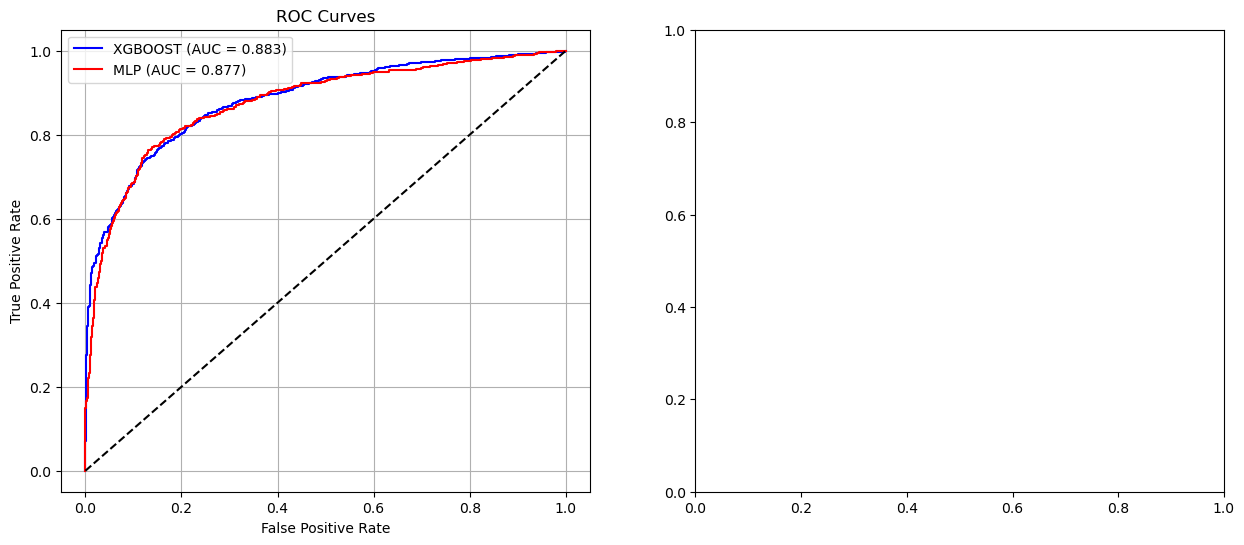

In [5]:
# Plot ROC and PR curves
plot_model_curves(results)

# Perform hyperparameter tuning
print("\nPerforming hyperparameter tuning...")
best_models = hyperparameter_tuning(
    data_dict['X_train'],
    data_dict['y_train'],
    data_dict['X_valid'],
    data_dict['y_valid']
)

In [6]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def perform_shap_analysis(model, X, feature_names, model_type='xgboost', output_dir='shap_results'):
    """
    Perform comprehensive SHAP analysis for a given model
    
    Parameters:
    - model: Trained model (XGBoost or MLP)
    - X: Feature matrix
    - feature_names: List of feature names
    - model_type: 'xgboost' or 'mlp'
    - output_dir: Directory to save SHAP plots
    """
    # Ensure output directory exists
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Select appropriate explainer based on model type
    if model_type == 'xgboost':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
    elif model_type == 'mlp':
        # For MLP, use kernel explainer (can be computationally expensive)
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X, 100))
        shap_values = explainer.shap_values(X)
    
    # Ensure shap_values is a numpy array
    shap_values = np.array(shap_values)
    
    # If binary classification, take the positive class SHAP values
    if len(shap_values.shape) > 2:
        shap_values = shap_values[1]
    
    # 1. Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_names, 
                      show=False, plot_type='bar')
    plt.title(f'SHAP Feature Importance - {model_type.upper()} Model')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{model_type}_shap_summary_bar.png')
    plt.close()
    
    # 2. Summary Plot (Detailed)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_names, 
                      show=False)
    plt.title(f'SHAP Feature Impact - {model_type.upper()} Model')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{model_type}_shap_summary_detailed.png')
    plt.close()
    
    # 3. Dependence Plots for Top Features
    # Identify top features
    feature_importance = np.abs(shap_values).mean(axis=0)
    top_features_indices = feature_importance.argsort()[-5:][::-1]
    
    # Create dependence plots for top features
    for idx in top_features_indices:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            idx, 
            shap_values, 
            X, 
            feature_names=feature_names,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature_names[idx]}')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{model_type}_shap_dependence_{feature_names[idx]}.png')
        plt.close()
    
    # 4. Compute and save feature importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap_value': np.abs(shap_values).mean(axis=0)
    }).sort_values('mean_abs_shap_value', ascending=False)
    
    feature_importance_df.to_csv(f'{output_dir}/{model_type}_feature_importance.csv', index=False)
    
    return {
        'explainer': explainer,
        'shap_values': shap_values,
        'feature_importance': feature_importance_df
    }

def comprehensive_shap_analysis(results, data_dict):
    """
    Perform SHAP analysis for both XGBoost and MLP models
    
    Parameters:
    - results: Dictionary containing trained models
    - data_dict: Dictionary containing data splits
    """
    # Get feature names
    feature_names = data_dict['X_test'].columns.tolist()
    
    # Perform SHAP analysis for XGBoost
    print("Performing SHAP Analysis for XGBoost...")
    xgb_shap_results = perform_shap_analysis(
        results['models']['xgboost'], 
        data_dict['X_test'], 
        feature_names, 
        model_type='xgboost'
    )
    
    # Perform SHAP analysis for MLP (requires scaled data)
    print("\nPerforming SHAP Analysis for MLP...")
    scaler = results['scaler']
    X_test_scaled = scaler.transform(data_dict['X_test'])
    
    mlp_shap_results = perform_shap_analysis(
        results['models']['mlp'], 
        X_test_scaled, 
        feature_names, 
        model_type='mlp'
    )
    
    return {
        'xgboost': xgb_shap_results,
        'mlp': mlp_shap_results
    }

# Add this to your main script after training models
# Assuming 'results' and 'data_dict' are available
shap_analysis_results = comprehensive_shap_analysis(results, data_dict)

# Print top features
print("\nTop Features by XGBoost SHAP Importance:")
print(shap_analysis_results['xgboost']['feature_importance'].head())

print("\nTop Features by MLP SHAP Importance:")
print(shap_analysis_results['mlp']['feature_importance'].head())

Performing SHAP Analysis for XGBoost...

Performing SHAP Analysis for MLP...


 52%|█████▏    | 995/1924 [114:00:45<106:27:00, 412.51s/it]  


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>